**Objective**: Create Visualisations to help answer the 2 questions below

**Author**: Matthew Thoomkuzhy

**Date Last edited**: 01/12/2024

---
# Data Visualisation

- Question 1: What influences the formation of communities in the music Industry

- Question 2: Do the top 100 artists act like monopolists?

In order to answer these question I will be carrying out investigations on the top 100 most listened to artists of 2023.

In [9]:
# Importing relevant modules

import sqlite3
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import seaborn as sns
from mplcursors import *
from lets_plot import *

  

---

# Network diagram for related artists:

- I am creating a network diagram using the related artist data in spotify to make relationships clear
- I will include the popularity of the artist by making artists with more followers larger nodes
- I will make more connected artists, with a higher degree, a lighter colour

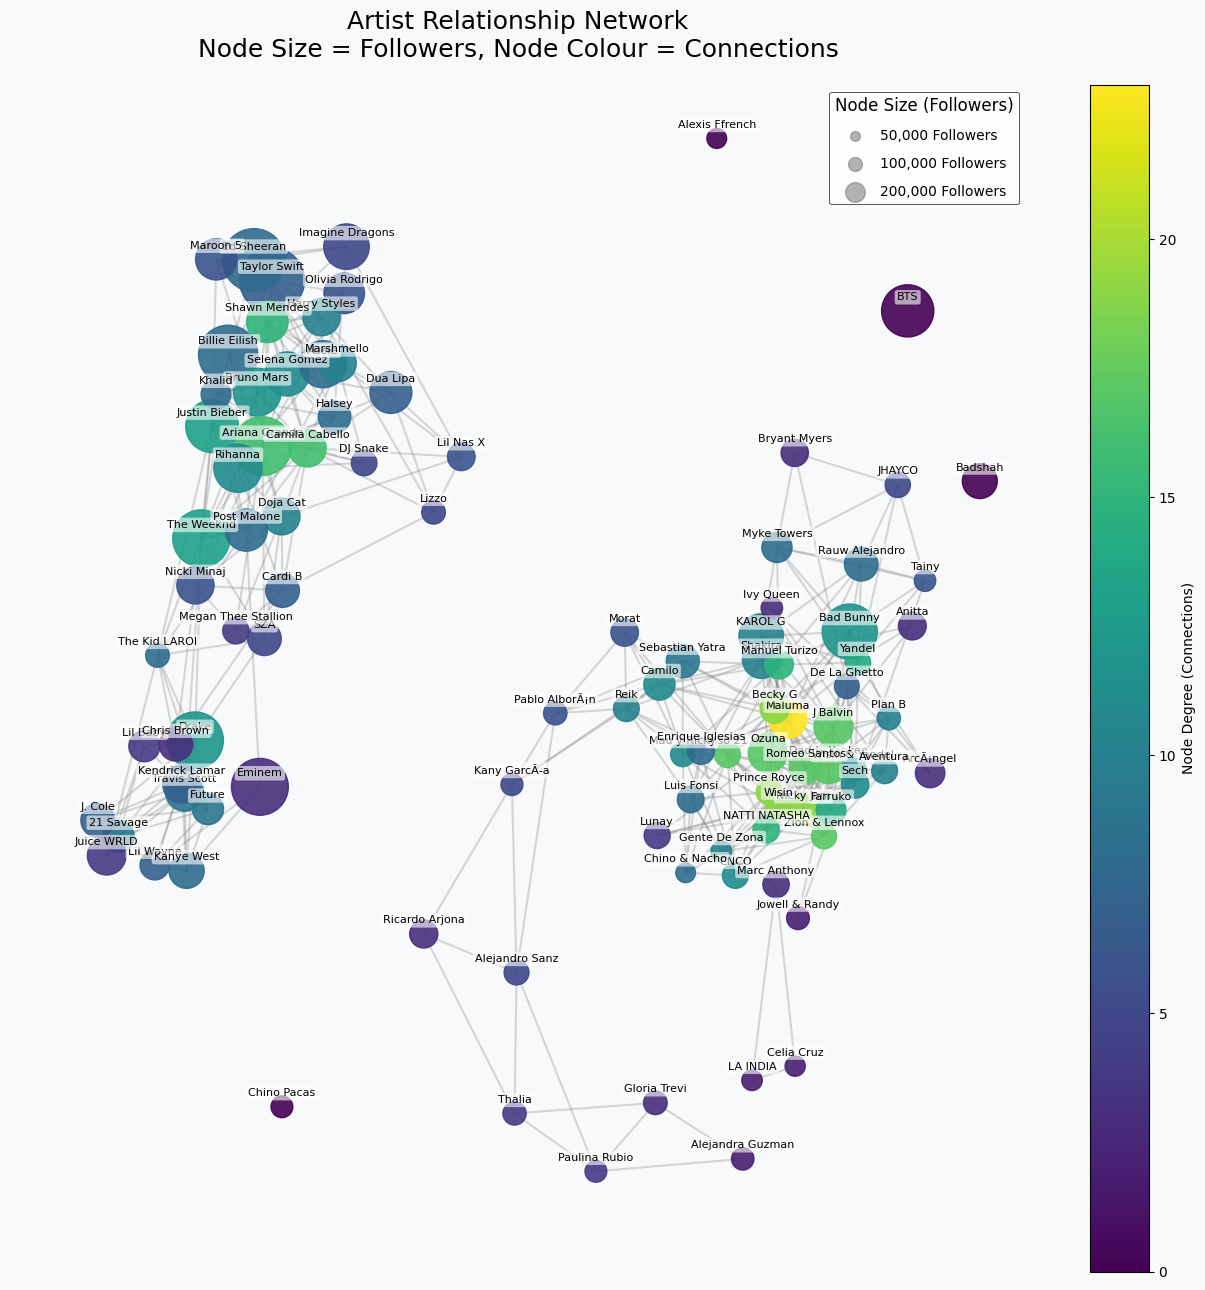

In [10]:

db_path = '../data/database/artist.db'
connection = sqlite3.connect(db_path)

# Query to fetch artist relationships and metadata
relationships_query = """
SELECT 
    am.Artist_Name AS artist_name, 
    am.Followers AS artist_followers,
    ar.Related_T100_Artist AS related_artist_name
FROM artist_relationships ar
JOIN artist_metadata am ON ar.Artist_ID = am.Artist_ID;
"""

metadata_query = """
SELECT 
    Artist_Name, 
    Followers
FROM artist_metadata;
"""

# Execute the queries and load the data into pandas DataFrames
artist_relationships_df = pd.read_sql_query(relationships_query, connection)
artist_metadata_df = pd.read_sql_query(metadata_query, connection)

# Close the database connection
connection.close()

# Identify artists without any relationships
related_artists = set(artist_relationships_df['artist_name']).union(
    artist_relationships_df['related_artist_name']
)
all_artists = set(artist_metadata_df['Artist_Name'])
isolated_artists = all_artists - related_artists

# Create a graph from the artist relationships
G = nx.Graph()

# Add edges to the graph and set followers as a node attribute
for _, row in artist_relationships_df.iterrows():
    G.add_edge(row['artist_name'], row['related_artist_name'])
    G.nodes[row['artist_name']]['followers'] = row['artist_followers']

# Add isolated artists as individual nodes
for artist in isolated_artists:
    followers = artist_metadata_df.loc[artist_metadata_df['Artist_Name'] == artist, 'Followers'].values[0]
    G.add_node(artist, followers=followers)

if len(G.nodes()) == 0:
    raise ValueError("The graph has no nodes. Verify the data in the database.")

# Extract node degrees (connections) and followers
node_degrees = dict(G.degree())
node_followers = {node: G.nodes[node].get('followers', 0) for node in G.nodes()}

# Normalize for coloring (degree centrality) and sizing (followers)
degree_values = list(node_degrees.values())
follower_values = list(node_followers.values())
degree_norm = Normalize(vmin=min(degree_values), vmax=max(degree_values))
size_norm = Normalize(vmin=min(follower_values), vmax=max(follower_values))

# Node sizes based on followers
node_sizes = [200 + (followers / max(follower_values)) * 2000 for followers in follower_values]

# Colours based on degree centrality
node_colors = degree_values  
colormap = plt.cm.viridis  # Use the 'viridis' colormap

fig, ax = plt.subplots(figsize=(13, 13), facecolor='#f8f9fa')

pos = nx.spring_layout(G, seed=42, k=0.38)  # Adjusted k value for more spacing

# Draw the network graph
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=colormap, alpha=0.9, ax=ax
)
edges = nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray", width=1.5, ax=ax)

# Offset labels for better readability
for node, (x, y) in pos.items():
    ax.text(
        x, y + 0.02,  # Offset for better readability
        s=node,
        horizontalalignment='center',
        fontsize=8,
        color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )

# Add a colourbar linked to the nodes
sm = ScalarMappable(norm=degree_norm, cmap=colormap)
sm.set_array(degree_values)  
cbar = fig.colorbar(sm, ax=ax, label="Node Degree (Connections)")
cbar.ax.tick_params(labelsize=10)

# Add a legend for node sizes based on followers
legend_entries = [(50, 500_00), (100, 1_000_00), (200, 2_000_00)]
for size, followers in legend_entries:
    ax.scatter([], [], c='gray', alpha=0.6, s=size, label=f"{followers:,} Followers")

legend = ax.legend(
    scatterpoints=1,
    frameon=True,
    framealpha=0.9,
    labelspacing=1,
    loc='upper right',
    title="Node Size (Followers)",
    title_fontsize=12
)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)

ax.set_title("Artist Relationship Network\nNode Size = Followers, Node Colour = Connections", fontsize=18, color='black', pad=20)
ax.axis("off")

output_path = '../data/visualisations/Artist_relationship_network'  
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()


### Key Findings:

1. **Language Influences the creation of related artist communities**

In relation to question 1 it is clear that langauge barrier plays a large role in whether or not communities form, notably the large chasm between the Spanish speaking artists and the English speaking artists is clear. 

This finding is exacerbated by the fact that Badshah and BTS, 2 relatively large artists, are left linkless as their songs are in Hindi and Korean respectively

2. **Sub communities form within larger communities**

In relation to question 1 we can start to infer that subcultures and subcommunities start to form within larger communities, this is evident through the cluster of rappers (21 savage, Future, etc.) on the left hand side in the 'English' cluster.

This can also be seen through the bundling of pop artists (Selena Gomez, Bruno Mars) higher up the English network. This points to Genre being a strong indicator of how related artists are according to spotify.

3. **There is no evident correlation between size of artist and their number of related artists for very popular artists**

Large names like Eminem and Taylorswift have very few connections whilst other large names like the Weekend, Bad Bunny and Maluma have more connections.

4. **The smallest artist in the top 100 are less likely to have related artists in the top 100**

Chino Pacas, Alexis Ffrench and a large number of the Spanish speaking cluster with few connections are examples of this. This could be because relatively smaller artists have more niche fanbases and less broadly appealing than more popular artists, so relate to less of the other artists. Although they may instead be related to smaller artists who won't appear in the sample 

5. **The Spanish music community is more diversified**

The fact there appears to be more smaller nodes (rather than fewer but larger) in the Spanish cluster could suggest the Spanish speaking world is more diversified in its taste of Spanish speaking musicians.

6. **The Spanish music community is more interconnected**

The colours of nodes of the Spanish speaking world appear more yellow on aggregate, suggesting more connections.

This is exacerbated by the presence of more small nodes incorporates into their network cluster


### Conclusion:

* Ultimately this graph shows that language and genre influence the forming of subcommunities. 

* It also suggests the music industry is more of a community duopoly (English and Spanish speakers) rather than a monopoly.




---

# Network diagram for artists connected by a common genre

I am going to be producing a similar graph but will instead form relationships for when artists have at least one genre in common

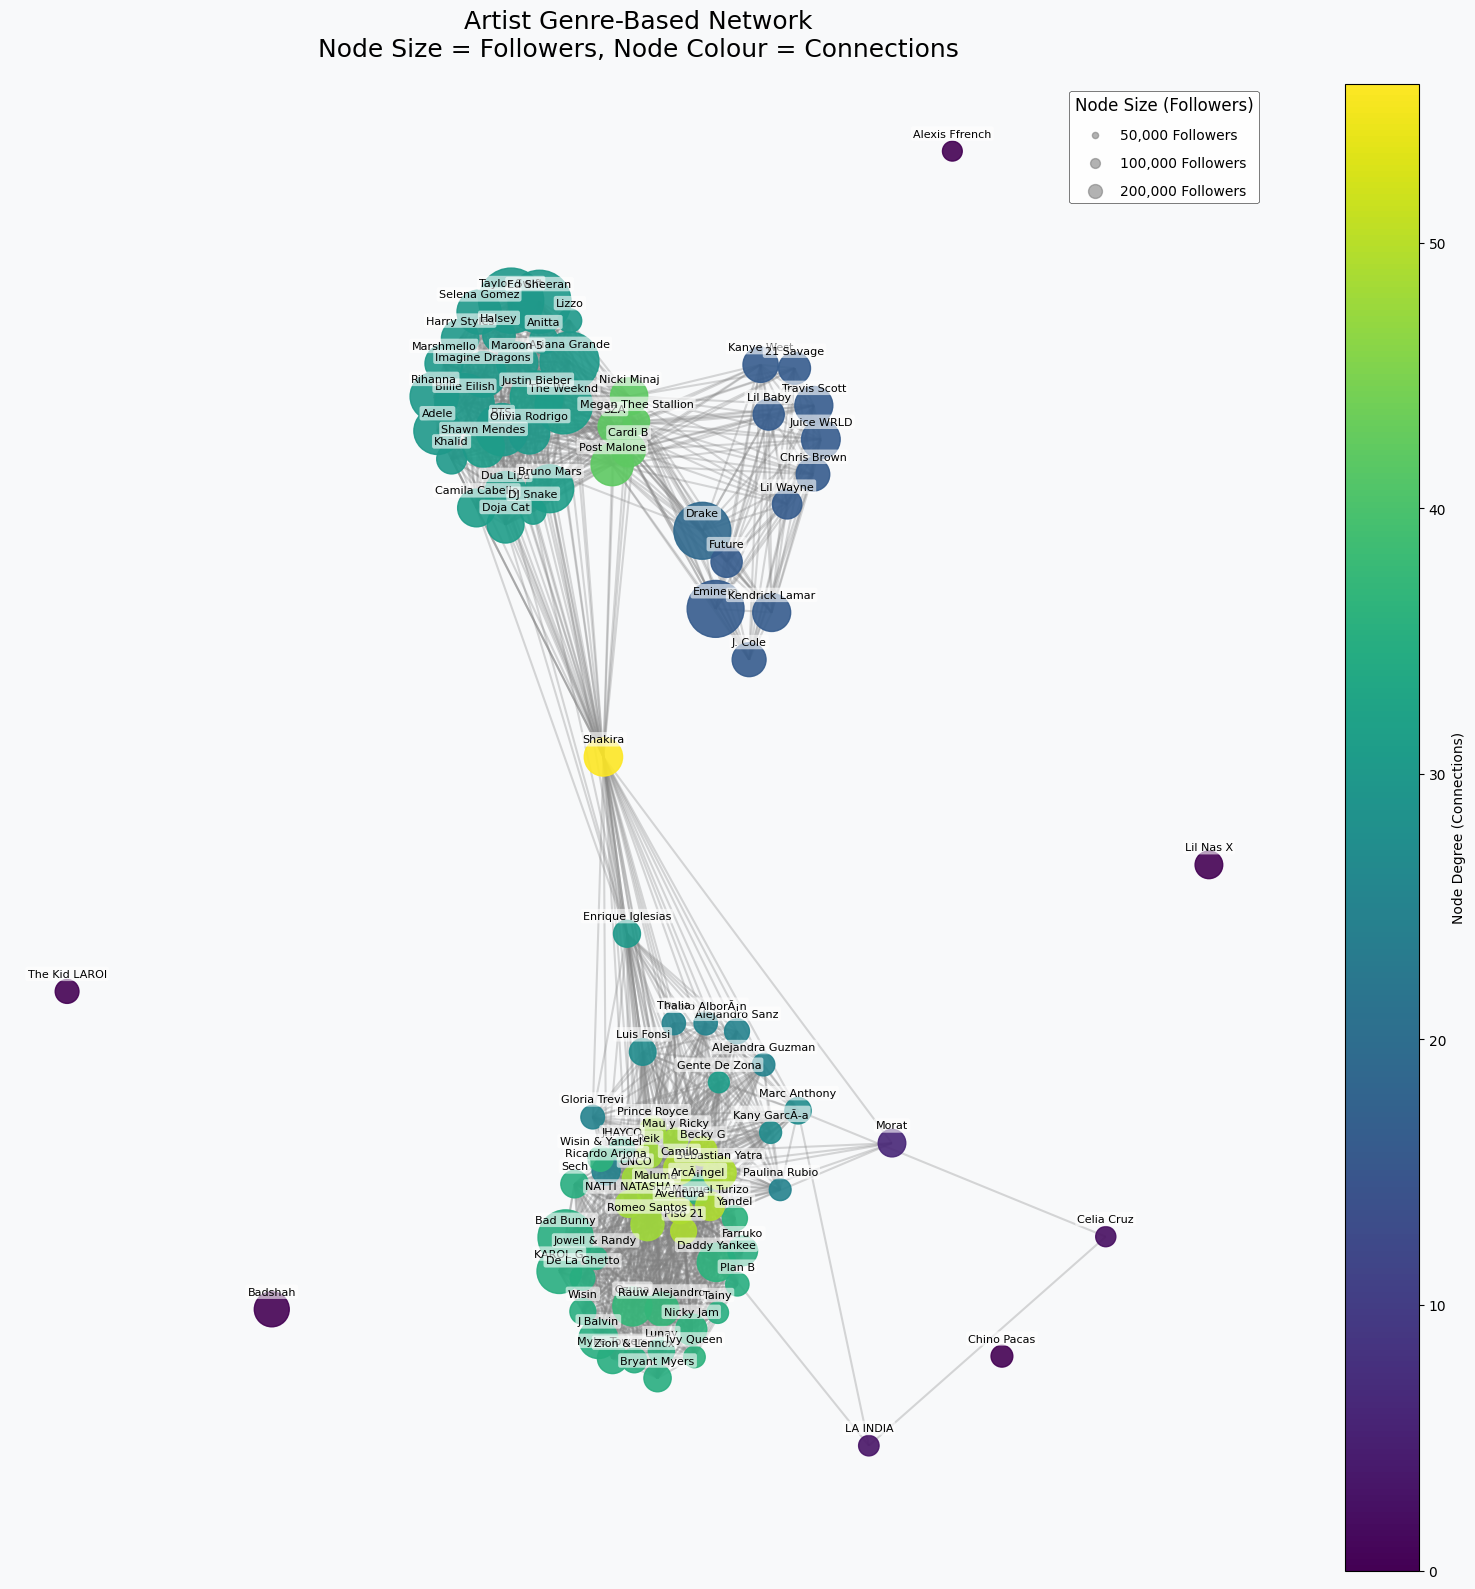

In [11]:


connection = sqlite3.connect(db_path)

# Query to fetch artist genres and metadata
query = """
SELECT 
    ag.Artist_ID AS artist_id, 
    ag.Genre AS genre, 
    am.Artist_Name AS artist_name,
    am.Followers AS followers
FROM artist_genres ag
JOIN artist_metadata am ON ag.Artist_ID = am.Artist_ID;
"""

# Execute the query and load the data into a pandas DataFrame
artist_genres_df = pd.read_sql_query(query, connection)

connection.close()

# Create a graph where artists are connected if they share a genre
G = nx.Graph()

# Add all artists as nodes with their followers
for _, row in artist_genres_df.iterrows():
    G.add_node(row['artist_name'], followers=row['followers'])

# Group by genre to find all artists sharing the same genre
for genre, group in artist_genres_df.groupby('genre'):
    artist_names = group['artist_name'].tolist()
    for i, artist1 in enumerate(artist_names):
        for artist2 in artist_names[i + 1:]:
            G.add_edge(artist1, artist2)

# Extract node degrees (connections) and followers
node_degrees = dict(G.degree())
node_followers = {node: G.nodes[node].get('followers', 0) for node in G.nodes()}

# Normalize for colouring (degree centrality) and sizing (followers)
degree_values = list(node_degrees.values())
follower_values = list(node_followers.values())
degree_norm = Normalize(vmin=min(degree_values), vmax=max(degree_values))
size_norm = Normalize(vmin=min(follower_values), vmax=max(follower_values))

# Node sizes based on followers
node_sizes = [200 + (followers / max(follower_values)) * 2000 for followers in follower_values]

# Colours based on degree centrality
node_colors = degree_values  # Use raw degree values for the colormap
colormap = plt.cm.viridis  # Use the 'viridis' colormap

fig, ax = plt.subplots(figsize=(16, 16), facecolor='#f8f9fa')

pos = nx.spring_layout(G, seed=42, k=0.55)  

# Draw the network graph
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=colormap, alpha=0.9, ax=ax
)
edges = nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray", width=1.5, ax=ax)

# Add labels for nodes 
for node, (x, y) in pos.items():
    ax.text(
        x, y + 0.02,  # Offset for better readability
        s=node,
        horizontalalignment='center',
        fontsize=8,
        color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )

# Add a colourbar linked to the nodes
sm = ScalarMappable(norm=degree_norm, cmap=colormap)
sm.set_array(degree_values)  # Associate ScalarMappable with degree values
cbar = fig.colorbar(sm, ax=ax, label="Node Degree (Connections)")
cbar.ax.tick_params(labelsize=10)

# Add a legend for node sizes based on followers
legend_entries = [(20, 500_00), (50, 1_000_00), (100, 2_000_00)]
for size, followers in legend_entries:
    ax.scatter([], [], c='gray', alpha=0.6, s=size, label=f"{followers:,} Followers")

legend = ax.legend(
    scatterpoints=1,
    frameon=True,
    framealpha=0.9,
    labelspacing=1,
    loc='upper right',
    title="Node Size (Followers)",
    title_fontsize=12
)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.4)

# Add a title
ax.set_title("Artist Genre-Based Network\nNode Size = Followers, Node Colour = Connections", fontsize=18, color='black', pad=20)
ax.axis("off")

output_path = '../data/visualisations/Genre_based_artist_network'  
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()


### Key Findings:


1. **Genre exacerbates the subcomunnities present**

Obviously the artists of each genre will appearch closer together, but now the formation of the subcommunities has been heavily exacerbated
This suggests spotify account for many factors other than genre when classing an artist as 'related'.


2. **There is nothing Shakira can't do!**

She is single handedly connecting the latin genres and the mainstream western pop genres together


3. **The popularity of each genre can be deduced from the colour codes**

the colour codes for all of the groups seem to be very consistent, so we can somewhat accurately estimate the relative presence of each genre in the top 100 artists, namely  latin pop > western pop > latin rap > western rap


4. **Artist Genre's are more clear cut in western music unlike in Spanish music**

Spanish Artists music genre's appear to be more dynamic. In the western cluster, the rappers, pop artists and inbetweeners (Cardi B and co) appear to form blocks. 

Whereas in the Spanish cluster a ring appears around the artists with the most genres, suggesting Spanish artists are more fluid/ cover a wider range of genre's


### Conclusion:

* Genre plays a larger role in western music culture when forming communities of artists



--- 

# Heat map analysis of track collaborations

I will be using the many to many table (for artists and tracks) in my database to deduce where artists have collaborated on the same song and produce a heat map of track collaborations

Click on the heatmap to further clarify which 2 artists have collabed and on how many tracks

In [18]:
# Initialize Lets-Plot
LetsPlot.setup_html()

# Database path
db_path = '../data/database/artist.db'
connection = sqlite3.connect(db_path)

# Query to fetch track-artist relationships
query = """
SELECT 
    ta.Track_ID AS track_id,
    am.Artist_Name AS artist_name
FROM track_artists ta
JOIN artist_metadata am ON ta.Artist_ID = am.Artist_ID;
"""

# Execute the query and load the data into a pandas DataFrame
track_artists_df = pd.read_sql_query(query, connection)
connection.close()

# Use groupby apply to map artists to tracks
artist_tracks = track_artists_df.groupby('artist_name')['track_id'].apply(set)

# Create an adjacency matrix for track collaborations
artist_names = artist_tracks.index.tolist()
adj_matrix = np.zeros((len(artist_names), len(artist_names)))

for i, artist1 in enumerate(artist_names):
    for j, artist2 in enumerate(artist_names):
        if i != j:  # Avoid self-connections
            adj_matrix[i, j] = len(artist_tracks[artist1] & artist_tracks[artist2])  # Shared tracks

# Convert adjacency matrix to a DataFrame for plotting
adj_df = pd.DataFrame(adj_matrix, columns=artist_names, index=artist_names)
adj_df = adj_df.reset_index().melt(id_vars='index')
adj_df.columns = ['artist1', 'artist2', 'shared_tracks']

# Plot the heatmap using Lets-Plot
heatmap = (
    ggplot(adj_df, aes(x='artist2', y='artist1', fill='shared_tracks'))
    + geom_tile(aes(color='shared_tracks'))
    + scale_fill_gradient(low="#FFFFFF", high="#440154")  # Viridis-like color palette
    + scale_color_gradient(low="#FFFFFF", high="#440154")
    + ggsize(700, 700)
    + ggtitle("Heatmap of Artist Collaborations by Shared Tracks")
    + xlab("Artists") + ylab("Artists")
    + theme(axis_text_x=element_text(size=8),
            axis_text_y=element_text(size=8),
            plot_title=element_text(size=16, hjust=0.5),  # Center the title
            axis_title_x=element_text(size=12),
            axis_title_y=element_text(size=12))
    + theme(axis_text_x=element_text(angle=90))  # Rotate x-axis labels
)
# Save the plot as an SVG file
output_file = "../../data/SVG's/Heatmap.svg"
ggsave(Song_durations, filename=output_file)
print(f"Plot saved as {output_file}")

# Display the heatmap
heatmap.show()


Plot saved as ../../data/SVG's/Heatmap.svg


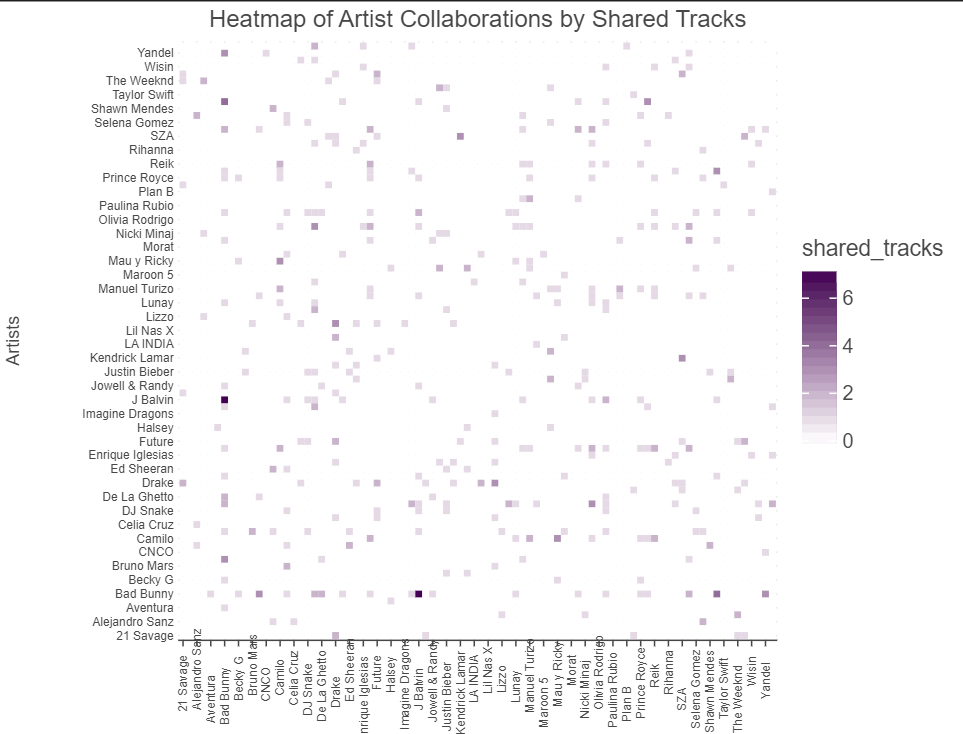

### Key Findings:


1. **J Balvin and Bad Bunny love to make music together!**

Very purple value

2. **Collaborations aren't as common as I thought**

There aren't a lot of purple values

3. **The idea that language forms communities is strengthened**

Artists who tend to have a very high number of shared tracks tend to come from the same language block e.g. Bad Bunny and Tainy (4), J Balvin and bad bunny

Spnaish artists tend to collaborate more, whihc mihgt explain why they tend to be assoicated with more than a few genres, supporting the finidng from the genre based network diagram.

Of western artists, rappers tend to collab more than pop artists e.g. Kendrick Lamar and Sza sharing 3 tracks. This Reinforces the idea that genre drives collaboration and the formation of musical communities



---

# Song Duration Analysis
I am going to be using a bar chart to analyse trends in song duration of the top 100 artists tracks

In [ ]:
# Import necessary libraries
from lets_plot import *
from lets_plot.export import ggsave
import pandas as pd
import sqlite3

# Initialize Lets-Plot
LetsPlot.setup_html()

# Query to fetch song durations from the database
query = """
SELECT 
    Track_ID, 
    Track_Name, 
    Duration
FROM artist_tracks;
"""

# Function to calculate duration intervals
def calculate_duration_intervals(df):
    df['duration_sec'] = df['Duration'] / 1000
    bins = range(0, int(df['duration_sec'].max()) + 30, 30)
    labels = [f"{i}-{i + 30}" for i in bins[:-1]]
    df['duration_interval'] = pd.cut(df['duration_sec'], bins=bins, labels=labels, right=False)
    interval_counts = df['duration_interval'].value_counts(normalize=True).sort_index()
    return interval_counts * 100

# Connect to SQLite database and fetch data
db_path = "../data/database/artist.db"  # Update with your actual database path
with sqlite3.connect(db_path) as connection:
    song_durations_df = pd.read_sql_query(query, connection)

# Calculate interval percentages
interval_percentages = (
    song_durations_df
    .groupby(lambda x: True)  # Apply to the entire dataset
    .apply(calculate_duration_intervals)
    .iloc[0]  # Extract the resulting Series from the group
)

# Prepare data for plotting
interval_percentages_df = interval_percentages.reset_index()
interval_percentages_df.columns = ['duration_interval', 'percentage']

# Plot using Lets-Plot
Song_durations = (
    ggplot(data=interval_percentages_df, mapping=aes(x='duration_interval', y='percentage'))
    + geom_bar(stat='identity', fill='#87CEEB', color='black', width=0.8)  # Using hex color
    + ggsize(800, 400)
    + ggtitle("Distribution of Songs by Duration Intervals")
    + theme(plot_title=element_text(hjust=0.5))  # Center the title
    + xlab("Duration Intervals (seconds)") + ylab("Percentage of Songs (%)")
)

# Save the plot as an SVG file
output_file = "../../data/SVG's/song_durations_plot.svg"
ggsave(Song_durations, filename=output_file)
print(f"Plot saved as {output_file}")

Song_durations




Plot saved as ../../data/SVG's/song_durations_plot.svg


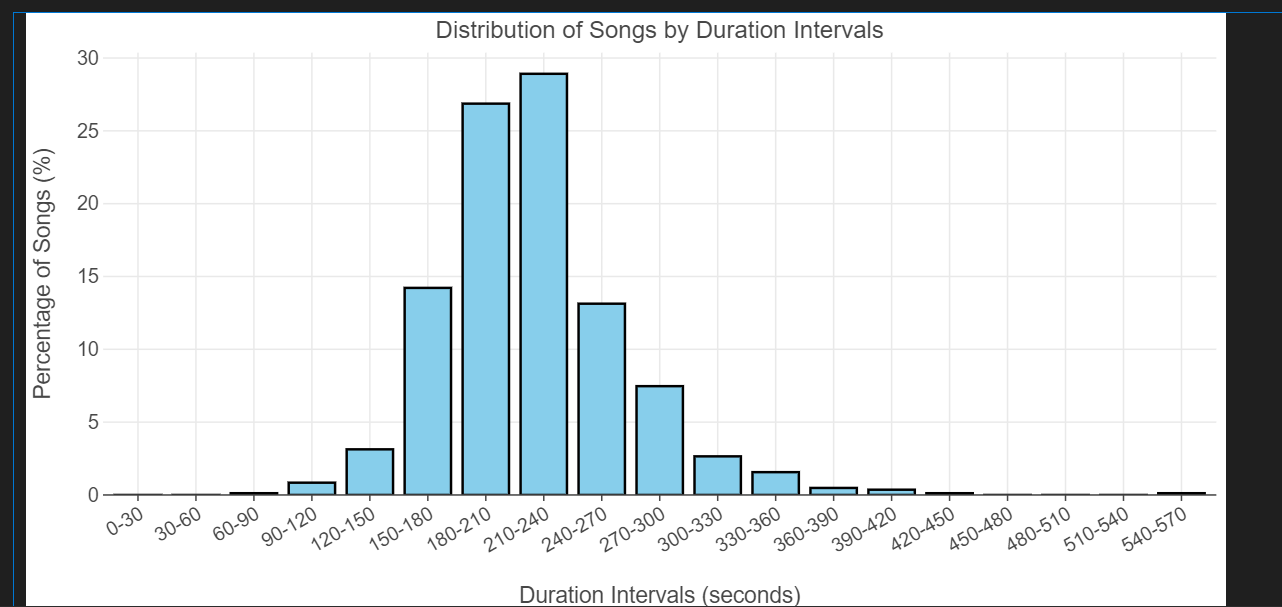

### Key Findings:


1. **Song durations follow a normal distribution**

 90.6% of songs last between 2.5 and 5 minutes

This organized behaviour or lack of product differentiation could be symbolic of monopoly behaviour.

This is a stretch, instead, artists may know that their is a physchologically ideal time for a track to last which will optimize their minutes listened to  (duration x number of streams)



---

# Analysis of inequality of followers

* I will be using artists followers as an indicator of their income

* I will be creating a lorenz curve to help visualize the magnitude of inequality of popularity of the top 100 artists and inform my insights.

In [17]:


# Initialize Lets-Plot
LetsPlot.setup_html()

# Path to the database
db_path = '../data/database/artist.db'

# Query to fetch artist follower counts from the artist_metadata table
query = """
SELECT 
    Artist_Name, 
    Followers
FROM artist_metadata;
"""

# Process data with groupby-apply-combine
def calculate_cumulative_followers(df):
    df_sorted = df.sort_values(by="Followers", ascending=True)
    followers = df_sorted['Followers'].values
    cumulative_artists = np.arange(1, len(followers) + 1) / len(followers)
    cumulative_followers = np.cumsum(followers) / followers.sum()
    return pd.DataFrame({
        'Cumulative_Artists': cumulative_artists,
        'Cumulative_Followers': cumulative_followers
    })

with sqlite3.connect(db_path) as connection:
    artist_followers_df = pd.read_sql_query(query, connection)

lorenz_data = (
    artist_followers_df
    .groupby(lambda x: True)  # Apply to the entire dataset
    .apply(calculate_cumulative_followers)
    .reset_index(drop=True)
)

# Calculate the Gini coefficient
area_under_curve = np.trapezoid(lorenz_data['Cumulative_Followers'], lorenz_data['Cumulative_Artists'])
gini_coefficient = 1 - 2 * area_under_curve

# Plot the Lorenz curve using Lets-Plot
lorenz_curve = (
    ggplot(lorenz_data, aes('Cumulative_Artists', 'Cumulative_Followers')) +
    geom_line(color='blue', size=1.2) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='gray') +
    geom_ribbon(aes(ymin='Cumulative_Artists', ymax='Cumulative_Followers'), fill='blue', alpha=0.2) +
    ggtitle(f"Lorenz Curve of Artist Followers\nGini Coefficient: {gini_coefficient:.2f}") +
    xlab("Cumulative Percentage of Artists") +
    ylab("Cumulative Percentage of Followers") +
    theme_minimal() +
    theme(
        title=element_text(size=16, face="bold"),
        axis_title=element_text(size=12),
        legend_position='none',
        plot_title=element_text(hjust=0.5)  # Center the title
    )
)
# Save the plot as an SVG file
output_file = "../../data/SVG's/Lorenz_curve.svg"
ggsave(Song_durations, filename=output_file)
print(f"Plot saved as {output_file}")

lorenz_curve.show()


Plot saved as ../../data/SVG's/Lorenz_curve.svg


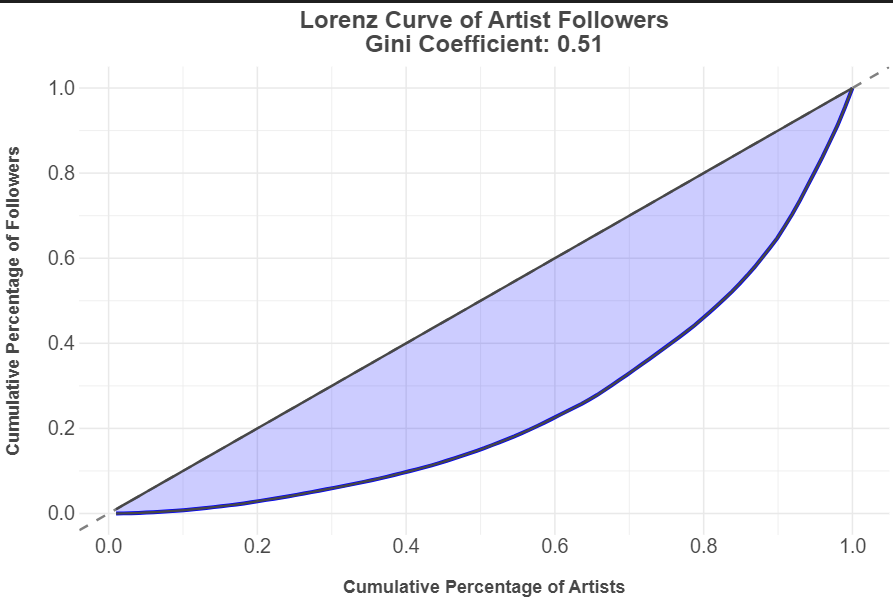

### Key findings:

**The distribution of followers is actually pretty uneven**

The average gini coefficient for g7 countries is 0.342, whereas for artists followers it is 0.51.

Although the average gini coefficient for the world is 0.67

Moreover I have only sampled the top 100 artists so the gini coefficient is likely to be higher for the hundreds of millions of artists on spotifies entire database.

These artists will have exponentially fewer followers, so whilst 0.5 is already high, it is still a severe underestimate

This could suggest a lot of power lies in the hands of very few famous artists

### Conclusion:
 the cream of the crop has a lot of influence! They could have monopoly power

---

# Follower Share of top 100 artists

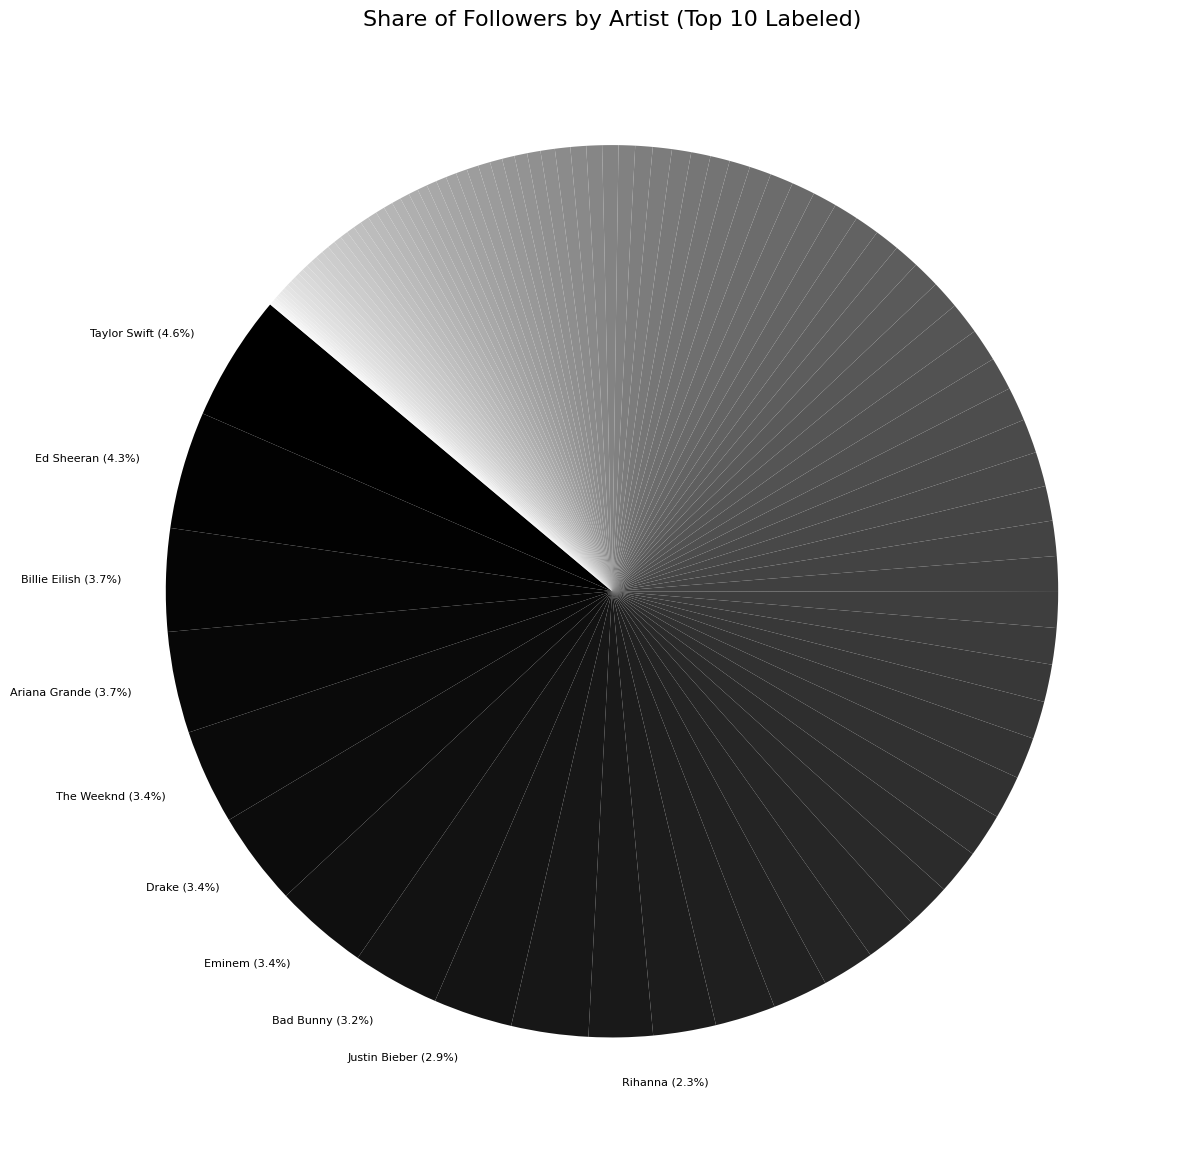

Pie chart saved to ../data/visualisations/artist_follower_share.png


In [103]:


# Reconnect to the database to fetch artist metadata
connection = sqlite3.connect('../data/database/artist.db')  

# Query to fetch artist names and followers
query = """
SELECT 
    Artist_Name, 
    Followers
FROM artist_metadata;
"""

# Execute the query and load the data into a pandas DataFrame
artist_followers_df = pd.read_sql_query(query, connection)

# Close the database connection
connection.close()

# Calculate total followers and percentage share
artist_followers_df['Share'] = (
    artist_followers_df['Followers'] / artist_followers_df['Followers'].sum()
) * 100

# Sort by follower count for a more readable chart
artist_followers_df = artist_followers_df.sort_values(by="Followers", ascending=False)

# Generate a gradient of shades from black to white
num_artists = len(artist_followers_df)
colors = [plt.cm.binary(1 - i / num_artists) for i in range(num_artists)]

# Label only the top 10 artists with both name and percentage
top_10_indices = artist_followers_df.index[:10]
labels = [
    f"{name} ({share:.1f}%)" if idx in top_10_indices else ''
    for idx, (name, share) in enumerate(zip(artist_followers_df['Artist_Name'], artist_followers_df['Share']))
]

# Create the pie chart
plt.figure(figsize=(12, 12))
plt.pie(
    artist_followers_df['Share'],
    labels=labels,
    colors=colors,
    startangle=140,
    textprops={'fontsize': 8}
)
plt.title("Share of Followers by Artist (Top 10 Labeled)", fontsize=16)
plt.tight_layout()

# Save the chart as a PNG file
output_path = '../data/visualisations/artist_follower_share.png'
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Pie chart saved to {output_path}")


### Findings

**Within the top 100 artists, the relative share of followers does not suggest a large level of monopoly power.**

The 3 firm concentration ratio for the music industry is 12.6% (which isn't alot)
But artists aren't firms, they often have incentives to collaborate rather than compete

### Conclusion: 
Consumer's music tastes are quite diverse

---

# Overall Conclusion:

- **Question 1: What influences the formation of communities in the music Industry?**

Largely language and genre, less so popularity. Genre matters less as a personal identifier for the Spanish speaking musicians.

We have observed that genre matters less for Spanish artists in comparison to western artists in the genre based network diagram.

We observed the effect of language in forming 2 large relational blocks in the related artists diagram

The effect of language is also observable in the artists colllaboration heat map

Ultimately I believe language is the largest reason for collaboration and formation of communities of artists


- **Question 2: Do the top 100 artists act like monopolists?**

 NO! Not really as collaborations aren't that frequent (evident from heat map)

 Also market share in followers doesn't produce large concentration ratios

 However followers are distributed quite unevenly (high gini coefficient)

They tend to produce songs of similar lengths but this isn't necessarily caused by monopoly behaviour, they may just be giving fans what they like.

Ultimately whilst music isn't a monopoly industry I do think that teh top 100 artists exhibit similar behaviours, but since this is the will of the people, who are the customers, I don't believe artists are acting like monopolists

